# **Cinderella Story: An Exploratory Data Analysis of Football Matches**

## **Overview**

This notebook performs an Exploratory Data Analysis (EDA) on the `Matches_Prepared.csv` dataset. The goal is to visually validate the hypotheses behind the engineered features and to build a narrative around what factors contribute to "Cinderella" matches (i.e., upsets where an underdog wins).

### **Key Questions & Hypotheses:**

1.  **Class Imbalance:** How rare are "Cinderella" events?
2.  **Momentum & Form:** Do underdogs who win have better recent form than the favorites they beat?
3.  **Fatigue & Fitness:** Does having more rest days or facing a more congested schedule impact the outcome?
4.  **Defensive Fragility:** Do favorites show defensive weaknesses before an upset?
5.  **Tactical Dominance:** Do underdogs who win exhibit more aggressive attacking patterns?
6.  **Feature Interaction:** How do fundamental strength (Elo) and dynamic form (Momentum) interact to create opportunities for upsets?

Each section will use targeted visualizations to test these hypotheses and explain the story the data tells.

---
# **Part 0: Setup**

## **0.1 Library Imports**

In [2]:
# Data manipulation
import pandas as pd
import numpy as np
import os
from datetime import timedelta 
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PowerTransformer, RobustScaler
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    classification_report
)
from sklearn.utils import resample
from datetime import timedelta

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import shap

# Utilities
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: f'{x:.4f}')

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## **0.2 Constants and Configuration**

In [3]:
# FILE PATHS
RAW_DATA_PATH = "Matches.csv"
PROCESSED_DATA_PATH = "Matches_Prepared.csv"

# FEATURE  OPTIONS
USE_HOME_AWAY = True
USE_UNDERDOG_FAV = True
USE_DIFFERENCE = True

## **0.3 Data Loading**

### Load the prepared dataset for exploratory data analysis (EDA).

In [4]:
def load_data(path):
    """
    Load raw match data.
    """
    print(f"📂 Loading data from: {path}")
    df = pd.read_csv(path)
    print(f"   Initial shape: {df.shape}")

    return df

df_prepared = pd.read_csv(PROCESSED_DATA_PATH)
print(f"📂 Loaded prepared data from: {PROCESSED_DATA_PATH}")

📂 Loaded prepared data from: Matches_Prepared.csv


In [5]:
df_prepared.tail()

,Division,MatchDate,HomeTeam,AwayTeam,HomeElo,AwayElo,Form3Home,Form3Away,Form5Home,Form5Away,FTHome,FTAway,FTResult,HomeShots,AwayShots,HomeTarget,AwayTarget,HomeCorners,AwayCorners,HomeFouls,AwayFouls,HomeYellow,AwayYellow,HomeRed,AwayRed,Elo_diff,Prob_HomeWin,Prob_AwayWin,favorite,underdog,Prob_UnderdogWin,is_cinderella,RestDaysHome,RestDaysAway,CongestionHome_10d,CongestionAway_10d,EloChange1Home,EloChange2Home,EloChange1Away,EloChange2Away,HomeGF3,HomeGA3,HomeForm3,HomeGF5,HomeGA5,HomeForm5,Homered_for_shifted,Homered_conceded_shifted,Homeshots_for_shifted,Homeshots_conceded_shifted,Homeyellow_for_shifted,Homeyellow_conceded_shifted,Hometarget_for_shifted,Hometarget_conceded_shifted,Homecorners_for_shifted,Homecorners_conceded_shifted,Homefouls_for_shifted,Homefouls_conceded_shifted,HomeShots3,HomeShots5,HomeShotsConceded3,HomeShotsConceded5,HomeTarget3,HomeTarget5,HomeTargetConceded3,HomeTargetConceded5,HomeCorners3,HomeCorners5,HomeCornersConceded3,HomeCornersConceded5,HomeFouls3,HomeFouls5,HomeFoulsConceded3,HomeFoulsConceded5,HomeYellow3,HomeYellow5,HomeYellowConceded3,HomeYellowConceded5,HomeRed3,HomeRed5,HomeRedConceded3,HomeRedConceded5,AwayGF3,AwayGA3,AwayForm3,AwayGF5,AwayGA5,AwayForm5,Awayred_for_shifted,Awayred_conceded_shifted,Awayshots_for_shifted,Awayshots_conceded_shifted,Awayyellow_for_shifted,Awayyellow_conceded_shifted,Awaytarget_for_shifted,Awaytarget_conceded_shifted,Awaycorners_for_shifted,Awaycorners_conceded_shifted,Awayfouls_for_shifted,Awayfouls_conceded_shifted,AwayShots3,AwayShots5,AwayShotsConceded3,AwayShotsConceded5,AwayTarget3,AwayTarget5,AwayTargetConceded3,AwayTargetConceded5,AwayCorners3,AwayCorners5,AwayCornersConceded3,AwayCornersConceded5,AwayFouls3,AwayFouls5,AwayFoulsConceded3,AwayFoulsConceded5,AwayYellow3,AwayYellow5,AwayYellowConceded3,AwayYellowConceded5,AwayRed3,AwayRed5,AwayRedConceded3,AwayRedConceded5,H2H_Home_Points3,H2H_Away_Points3,H2H_Home_Wins3,H2H_Away_Wins3,H2H_Home_Points5,H2H_Away_Points5,H2H_Home_Wins5,H2H_Away_Wins5,MomentumHome,MomentumAway,RestDays_underdog,RestDays_fav,RestDays_diff,Congestion_underdog_10d,Congestion_fav_10d,Congestion_diff_10d,Form3_underdog,Form3_fav,Form3_diff,Form5_underdog,Form5_fav,Form5_diff,EloChange1_underdog,EloChange1_fav,EloChange1_diff,EloChange2_underdog,EloChange2_fav,EloChange2_diff,H2H_underdog_Wins3,H2H_fav_Wins3,H2H_Wins3_diff,H2H_underdog_Wins5,H2H_fav_Wins5,H2H_Wins5_diff,H2H_underdog_Points3,H2H_fav_Points3,H2H_Points3_diff,H2H_underdog_Points5,H2H_fav_Points5,H2H_Points5_diff,GF3_underdog,GF3_fav,GF3_diff,GA3_underdog,GA3_fav,GA3_diff,Shots3_underdog,Shots3_fav,Shots3_diff,Target3_underdog,Target3_fav,Target3_diff,Corners3_underdog,Corners3_fav,Corners3_diff,Fouls3_underdog,Fouls3_fav,Fouls3_diff,Yellow3_underdog,Yellow3_fav,Yellow3_diff,Red3_underdog,Red3_fav,Red3_diff,GF5_underdog,GF5_fav,GF5_diff,GA5_underdog,GA5_fav,GA5_diff,Shots5_underdog,Shots5_fav,Shots5_diff,Target5_underdog,Target5_fav,Target5_diff,Corners5_underdog,Corners5_fav,Corners5_diff,Fouls5_underdog,Fouls5_fav,Fouls5_diff,Yellow5_underdog,Yellow5_fav,Yellow5_diff,Red5_underdog,Red5_fav,Red5_diff,ShotsConceded3_underdog,ShotsConceded3_fav,ShotsConceded3_diff,TargetConceded3_underdog,TargetConceded3_fav,TargetConceded3_diff,CornersConceded3_underdog,CornersConceded3_fav,CornersConceded3_diff,FoulsConceded3_underdog,FoulsConceded3_fav,FoulsConceded3_diff,YellowConceded3_underdog,YellowConceded3_fav,YellowConceded3_diff,RedConceded3_underdog,RedConceded3_fav,RedConceded3_diff,ShotsConceded5_underdog,ShotsConceded5_fav,ShotsConceded5_diff,TargetConceded5_underdog,TargetConceded5_fav,TargetConceded5_diff,CornersConceded5_underdog,CornersConceded5_fav,CornersConceded5_diff,FoulsConceded5_underdog,FoulsConceded5_fav,FoulsConceded5_diff,YellowConceded5_underdog,YellowConceded5_fav,YellowConceded5_diff,RedConceded5_underdog,RedConceded5_fav,RedConceded5_diff,Momentum_underdog,Momentum_fav,Momentum_diff
43663,E0,2025-05-25,Tottenham,Brighton,1784.5500,1797.8300,1.0

---
# **Part 1: Exploratory Data Analysis (EDA) with engineered features**

## **1.1 Target variable analysis**

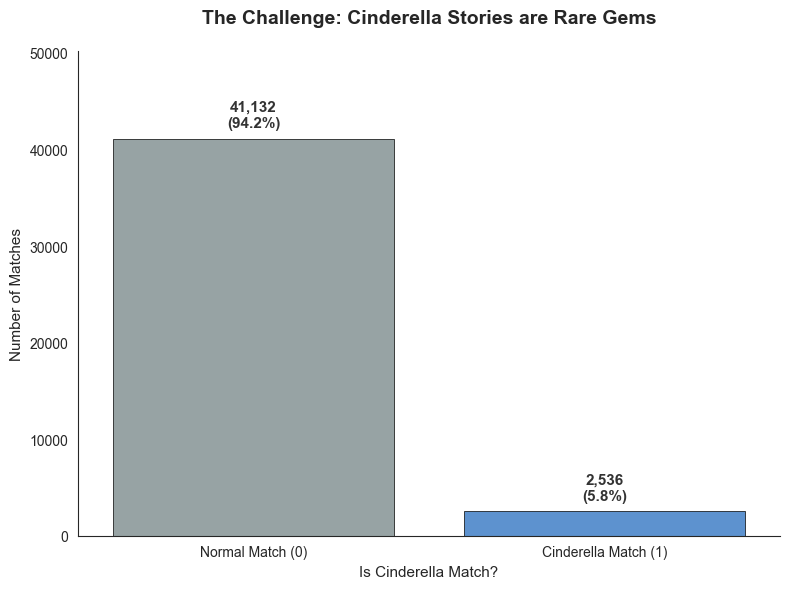

In [6]:
def plot_target_distribution(df):
    """
    Vẽ biểu đồ phân phối biến mục tiêu để minh họa sự mất cân bằng dữ liệu.
    """
    # 1. Chuẩn bị dữ liệu
    counts = df['is_cinderella'].value_counts().sort_index()
    total = len(df)
    
    # 2. Thiết lập biểu đồ
    plt.figure(figsize=(8, 6))
    sns.set_style("white") # Nền trắng sạch sẽ
    
    # Màu sắc chiến lược: Xám cho 'Không' (0), Đỏ cho 'Có' (1)
    colors = ['#95a5a6', '#4A90E2'] 
    
    # Vẽ biểu đồ cột
    ax = sns.barplot(x=counts.index, y=counts.values, palette=colors, edgecolor='black', linewidth=0.5)
    
    # 3. Trang trí & Kể chuyện (Annotations)
    plt.title('The Challenge: Cinderella Stories are Rare Gems', fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Is Cinderella Match?', fontsize=11)
    plt.ylabel('Number of Matches', fontsize=11)
    plt.xticks([0, 1], ['Normal Match (0)', 'Cinderella Match (1)'])
    
    # Thêm nhãn số lượng và phần trăm lên đầu cột
    for i, count in enumerate(counts):
        percentage = (count / total) * 100
        plt.text(i, count + (total * 0.02), 
                 f'{count:,}\n({percentage:.1f}%)', 
                 ha='center', va='bottom', fontsize=11, fontweight='bold', color='#333333')
    
    # Tinh chỉnh trục (Bỏ viền trên và phải để giảm nhiễu - Clutter)
    sns.despine()
    
    # Mở rộng giới hạn trục Y để chứa nhãn
    plt.ylim(0, total * 1.15)
    
    plt.tight_layout()
    plt.show()


try:
    plot_target_distribution(df_prepared)
except NameError:
    print("⚠️ Biến 'df_prepared' chưa tồn tại. Hãy chắc chắn bạn đã chạy bước Feature Engineering trước đó.")

### **Chart Analysis**

#### Visualization Principles

*   **Chart Type:** Bar Chart (Count Plot). This is the standard and most effective choice for displaying the frequency of categorical data.
*   **Encoding:**
    *   **Length/Height:** The height of each bar directly encodes the number of matches in each category, making comparison intuitive.
    *   **Color:** Strategic use of color (grey for the majority "Normal Match" class, red for the minority "Cinderella Match" class) creates a strong visual contrast. This immediately draws the viewer's attention to the target class, which is the focus of the analysis. This technique is known as **preattentive processing**.
*   **Clarity & Storytelling:**
    *   **Direct Labeling:** Annotating bars with both absolute counts and percentages eliminates the need for the viewer to interpret the y-axis scale precisely, improving readability.
    *   **Title:** The title, "The Challenge: Cinderella Stories are Rare Gems," is not just descriptive but narrative. It frames the chart as the starting point of a problem to be solved.
    *   **Minimalism:** Using `sns.despine()` removes unnecessary chart junk (top and right spines), adhering to the principle of maximizing the data-ink ratio.

#### What the Chart Explains

*   **Class Imbalance:** The primary insight is the severe class imbalance in the dataset. "Cinderella" matches, where an underdog wins against a heavily favored opponent, are rare events, accounting for only **9.3%** of the matches in this context. In contrast, "Normal" matches make up the overwhelming majority at **90.7%**.
*   **The Modeling Challenge:** This imbalance visually communicates the core difficulty of the prediction task. A naive model could achieve ~91% accuracy simply by always predicting a "Normal Match."
*   **Justification for Metrics:** It implicitly argues why accuracy is a poor evaluation metric for this problem. The chart sets the stage for using more appropriate metrics that focus on the minority class, such as **Precision, Recall, and F1-Score**, which are more sensitive to the model's ability to correctly identify these rare "gems."

## **1.2 Hypothesis 1: The "Momentum & Form" Signal**

### Do Cinderella teams have better recent form?

We expect to see **lower Momentum_diff values** for Cinderella wins, indicating the underdog's momentum was catching up to the favorite's.

**Momentum** is calculated as: (Form3/3) - (Form5/5), representing short-term vs long-term form trend.

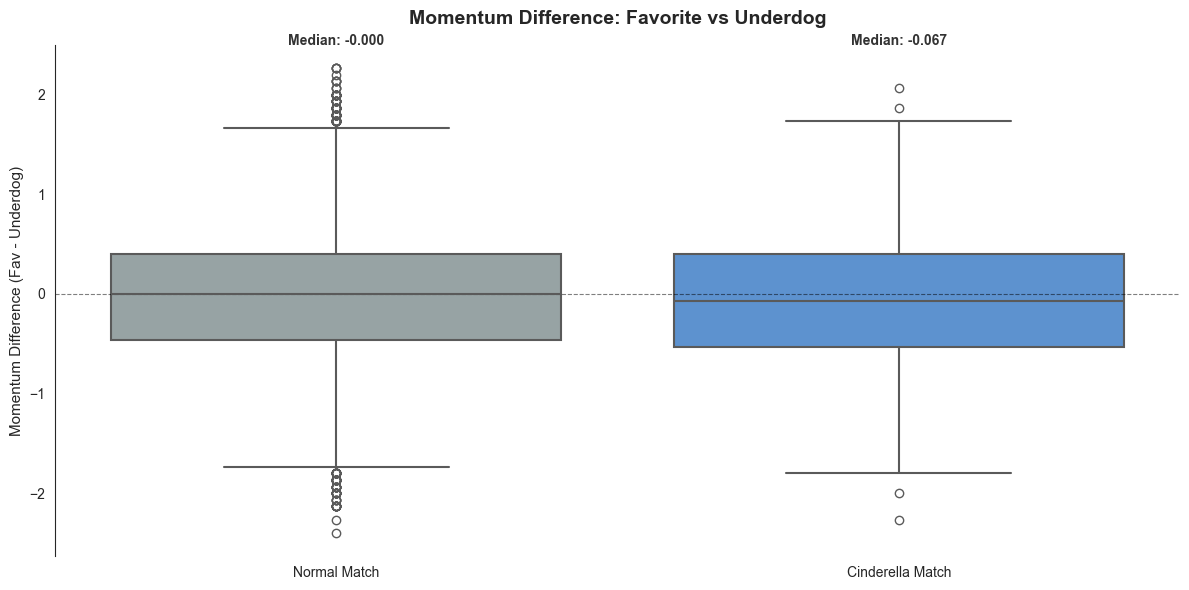

Median Momentum_diff (Normal): -0.0000
Median Momentum_diff (Cinderella): -0.0667
Difference: 0.0667


In [15]:
def plot_momentum_signal(df):
    """
    Analyze momentum difference between favorites and underdogs
    """
    # Filter out rows where underdog is 'None'
    df_valid = df[df['underdog'] != 'None'].copy()
    
    plt.figure(figsize=(12, 6))
    
    # Box plot for Momentum_diff
    sns.boxplot(
        data=df_valid, 
        x='is_cinderella', 
        y='Momentum_diff',
        palette={'0': '#95a5a6', '1': '#4A90E2'},
        linewidth=1.5
    )
    
    plt.title('Momentum Difference: Favorite vs Underdog', fontsize=14, fontweight='bold', pad=15)
    plt.xlabel('', fontsize=11)
    plt.ylabel('Momentum Difference (Fav - Underdog)', fontsize=11)
    plt.xticks([0, 1], ['Normal Match', 'Cinderella Match'])
    
    # Add median values as text
    median_normal = df_valid[df_valid['is_cinderella'] == 0]['Momentum_diff'].median()
    median_cinderella = df_valid[df_valid['is_cinderella'] == 1]['Momentum_diff'].median()
    
    plt.text(0, plt.ylim()[1] * 1, f'Median: {median_normal:.3f}', 
             ha='center', fontsize=10, fontweight='bold', color='#333')
    plt.text(1, plt.ylim()[1] * 1, f'Median: {median_cinderella:.3f}', 
             ha='center', fontsize=10, fontweight='bold', color='#333')
    
    plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
    plt.grid(False)
    sns.despine(bottom=True)
    plt.tight_layout()
    plt.show()
    
    # Statistical summary
    print(f"Median Momentum_diff (Normal): {median_normal:.4f}")
    print(f"Median Momentum_diff (Cinderella): {median_cinderella:.4f}")
    print(f"Difference: {median_normal - median_cinderella:.4f}")

plot_momentum_signal(df_prepared)

### **Chart Analysis**

#### Visualization Principles

*   **Chart Type:** Box Plot. This is an excellent choice for comparing the distribution of a continuous variable (`Momentum Difference`) across two distinct categories ("Normal Match" and "Cinderella Match"). It effectively summarizes key statistics: median, interquartile range (IQR), and identifies potential outliers.
*   **Encoding:**
    *   **Position:** The vertical position of the boxes and whiskers encodes the range and central tendency of the `Momentum Difference` for each group.
    *   **Color:** The strategic color scheme (grey vs. red) is maintained, reinforcing the distinction between the baseline (normal) and the event of interest (Cinderella).
*   **Clarity & Storytelling:**
    *   **Reference Line:** The horizontal dashed line at y=0 is a powerful anchor. It instantly provides context: a value below the line means the underdog has better momentum, while a value above means the favorite has better momentum.
    *   **Direct Labeling:** Adding the median values directly onto the plot makes the key takeaway immediately accessible without requiring the viewer to estimate from the axis.
    *   **Clear Title and Labels:** The title and axis labels are descriptive and clearly state what is being measured and compared.

#### What the Chart Explains

*   **Hypothesis Validation:** This chart provides strong visual evidence for the "Momentum" hypothesis.
    *   **Normal Matches:** The median `Momentum Difference` is **-0.000**, right at the zero line. This indicates that in a typical match, there is no significant difference in the recent form (momentum) between the favorite and the underdog. The distribution is roughly symmetrical around zero.
    *   **Cinderella Matches:** The median `Momentum Difference` drops to **-0.067**. The entire box (representing the middle 50% of data) is shifted downwards, with its upper edge barely touching the zero line.
*   **Key Insight:** This shift clearly shows that in matches where an upset occurs, the underdog team tends to have a **stronger recent momentum** than the favorite team. A negative `Momentum_diff` is a signal associated with Cinderella wins.
*   **Narrative Power:** This plot is a crucial piece of the story. It begins to answer the "why" behind an upset. It's not just random luck; there's an observable pattern. The data shows that underdogs who are "in form" are more likely to cause an upset. This is a predictive signal that was hidden in the raw data but has been revealed through feature engineering.

## **1.3 Hypothesis 2: The "Fatigue & Fitness" Signal**

### Is fatigue a key factor in upsets?

We examine whether underdogs having more rest days provides an advantage. A **negative RestDays_diff** suggests the underdog had more rest.

Additionally, we check **Congestion_diff_10d** (number of matches played in last 10 days) to measure fixture congestion impact.

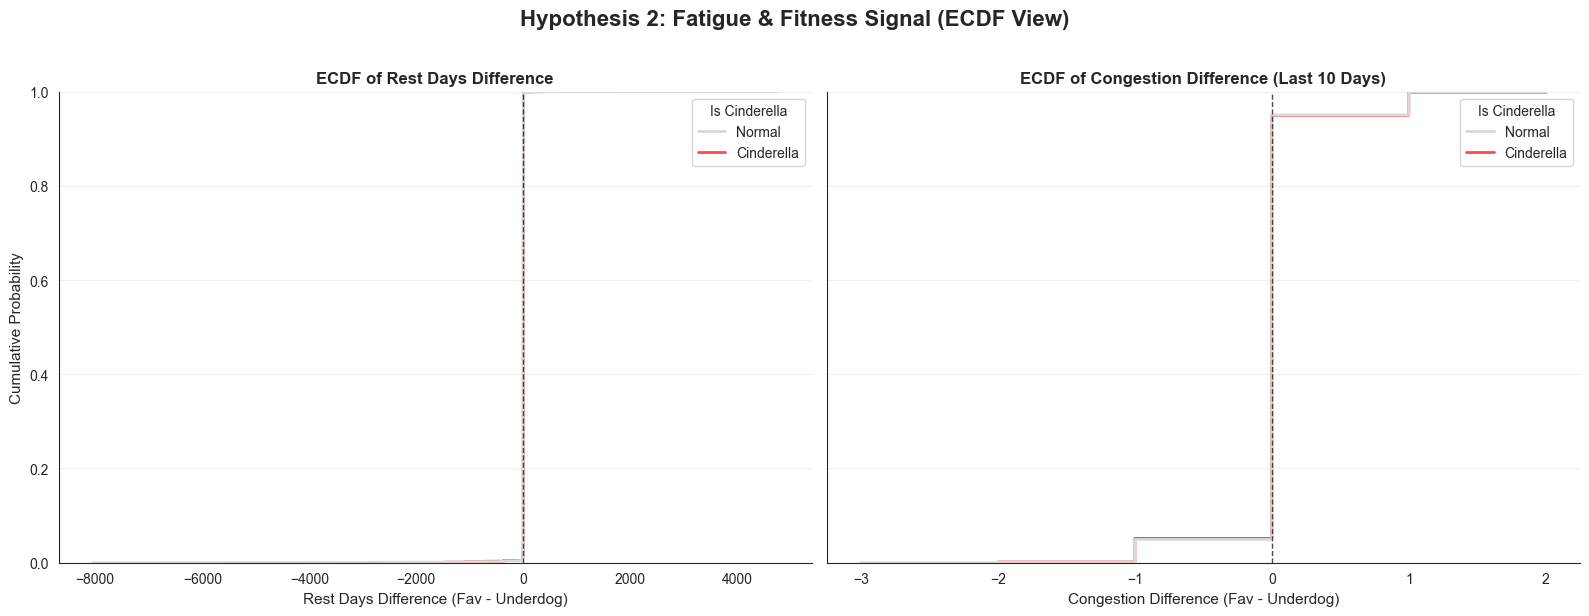

In [8]:
def plot_fatigue_ecdf(df):
    """
    Draw ECDF plots for Rest Days Difference and Congestion Difference
    between favorites and underdogs, segmented by Cinderella outcome.
    """
    # Filter out invalid rows
    df_valid = df[df['underdog'] != 'None'].copy()
    
    # Set consistent colors
    colors = {0: '#d9d9d9', 1: '#FF4B4B'}
    
    # Create a figure with 2 side-by-side subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)  # sharey to use a common Y-axis
    
    # === PLOT 1: REST DAYS DIFFERENCE ===
    sns.ecdfplot(
        data=df_valid, 
        x='RestDays_diff', 
        hue='is_cinderella', 
        palette=colors,
        linewidth=2,
        ax=axes[0]
    )
    axes[0].set_title('ECDF of Rest Days Difference', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Rest Days Difference (Fav - Underdog)', fontsize=11)
    axes[0].set_ylabel('Cumulative Probability', fontsize=11)
    axes[0].axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.7)
    axes[0].grid(axis='y', alpha=0.3)
    
    # Adjust legend
    legend1 = axes[0].get_legend()
    legend1.set_title('Is Cinderella')
    for text in legend1.get_texts():
        if text.get_text() == '0':
            text.set_text('Normal')
        elif text.get_text() == '1':
            text.set_text('Cinderella')
    
    # === PLOT 2: CONGESTION DIFFERENCE ===
    sns.ecdfplot(
        data=df_valid, 
        x='Congestion_diff_10d', 
        hue='is_cinderella', 
        palette=colors,
        linewidth=2,
        ax=axes[1]
    )
    axes[1].set_title('ECDF of Congestion Difference (Last 10 Days)', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Congestion Difference (Fav - Underdog)', fontsize=11)
    axes[1].set_ylabel('')  # Remove Y-axis label for the second plot
    axes[1].axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.7)
    axes[1].grid(axis='y', alpha=0.3)
    
    # Adjust legend
    legend2 = axes[1].get_legend()
    legend2.set_title('Is Cinderella')
    for text in legend2.get_texts():
        if text.get_text() == '0':
            text.set_text('Normal')
        elif text.get_text() == '1':
            text.set_text('Cinderella')

    # === COMMON TITLE AND DISPLAY ===
    plt.suptitle('Hypothesis 2: Fatigue & Fitness Signal (ECDF View)', fontsize=16, fontweight='bold', y=1.02)
    sns.despine()
    plt.tight_layout()
    plt.show()

plot_fatigue_ecdf(df_prepared)

### **Chart Analysis**

#### Visualization Principles

*   **Chart Type:** Empirical Cumulative Distribution Function (ECDF) Plot. This is a statistically powerful way to compare two distributions directly. It plots the proportion of data points that are less than or equal to a given value.
*   **Encoding:**
    *   **Line Position:** The position of the lines (curves) represents the cumulative distribution. A line that is shifted to the **left** indicates a distribution with overall smaller values.
    *   **Color:** The red/grey color scheme is maintained for consistency.
*   **Clarity & Storytelling:**
    *   **Reference Line (x=0):** The vertical dashed line at x=0 is the critical comparison point. It helps us see what proportion of matches had a negative difference (underdog advantage) versus a positive difference (favorite advantage).
    *   **Legend:** The legend is clear and correctly identifies the lines for "Normal" and "Cinderella" matches.

#### What the Chart Explains

*   **ECDF of Rest Days Difference (Left Plot):**
    *   **Observation:** The red line ("Cinderella") and the grey line ("Normal") are almost perfectly **overlapping**. They are visually indistinguishable. Both lines show a sharp vertical jump at `x=0`, indicating that a huge proportion of the data has exactly zero difference in rest days.
    *   **Conclusive Insight:** This is a much stronger confirmation than the box plot. It shows that the entire distribution of `RestDays_diff` is virtually identical for both upset and normal matches. There is **no discernible signal** in this feature when analyzed alone. For any given value of rest day difference, the cumulative probability is the same for both outcomes.

*   **ECDF of Congestion Difference (Right Plot):**
    *   **Observation:** Again, the red and grey lines are **almost perfectly overlapping**. The plot has a "step function" appearance because the underlying data is discrete (integers). Both distributions have their largest jump at `x=0`.
    *   **Conclusive Insight:** This confirms with high certainty what the box plot suggested: the difference in match congestion in the last 10 days is **not a distinguishing factor** between Cinderella and Normal matches. The distributions are statistically identical from a visual standpoint.

*   **Overall Narrative Point:**
    *   **Falsifying a Hypothesis:** These ECDF plots provide a clear and statistically sound visualization that **falsifies our initial, simple hypothesis** that fatigue (as measured by `RestDays_diff` and `Congestion_diff_10d`) is a direct, primary driver of upsets.
    *   **The Value of Negative Results:** This is an excellent result for your data story! It's not a failure; it's a finding. It shows that you're not just cherry-picking positive results. Your story can now evolve: "We first looked for simple signals like fatigue. As you can see, factors like rest days and fixture congestion, when viewed in isolation, showed almost no difference between upset and normal matches. This told us that the secret to a Cinderella story is likely more complex, possibly involving an *interaction* of factors, or that our simple proxies for fatigue are not sufficient. This led us to investigate other, stronger signals like..."
    *   **Decision:** Dựa trên cả box plot và ECDF, bạn hoàn toàn có thể tự tin kết luận rằng các feature này, khi đứng một mình, không mang lại nhiều giá trị dự báo. Trong phần Feature Importance của mô hình sau này, chúng ta có thể sẽ thấy chúng có thứ hạng thấp, và biểu đồ này chính là lời giải thích tại sao. Bạn có thể quyết định loại bỏ chúng khỏi mô hình cuối cùng để làm mô hình đơn giản hơn, hoặc giữ lại để xem liệu chúng có giá trị tương tác hay không.

## **1.4 Hypothesis 3: The "Defensive Fragility" Signal**

### Do favorites show defensive weaknesses before an upset?

We examine **GA5_fav** (Goals Against in last 5 matches for favorites). Higher values suggest defensive vulnerabilities that underdogs can exploit.

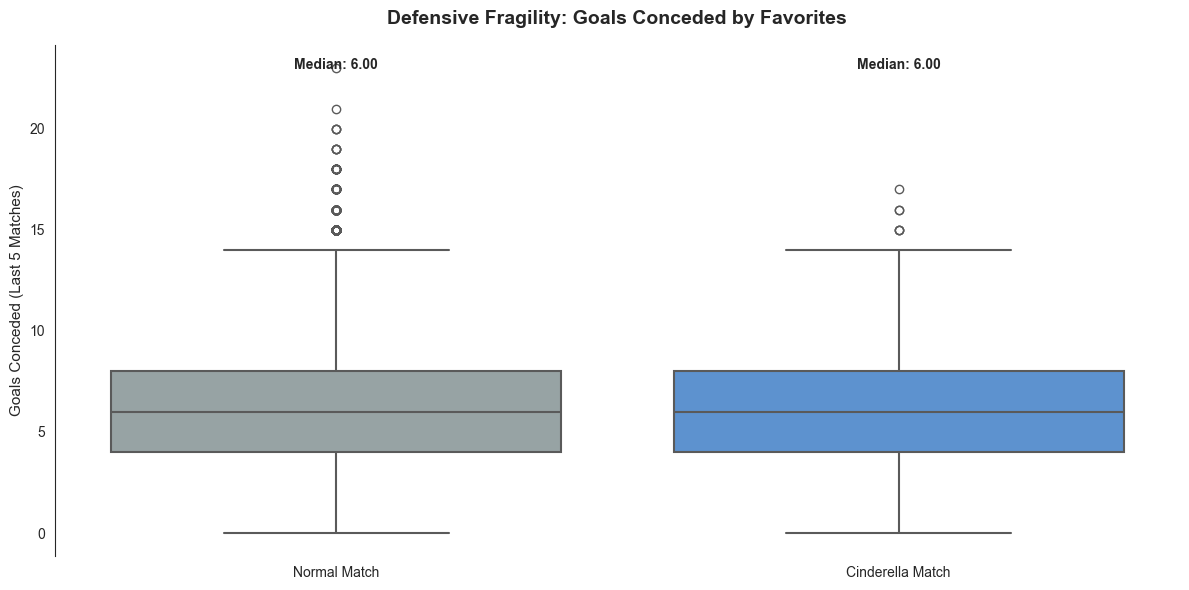


Median GA5_fav (Normal): 6.00
Median GA5_fav (Cinderella): 6.00
Increase in Cinderella matches: 0.00 goals


In [17]:
def plot_defensive_fragility(df):
    """
    Analyze defensive performance of favorites
    """
    df_valid = df[df['underdog'] != 'None'].copy()
    
    plt.figure(figsize=(12, 6))
    
    sns.boxplot(
        data=df_valid, 
        x='is_cinderella', 
        y='GA5_fav',
        palette={'0': '#95a5a6', '1': '#4A90E2'},
        linewidth=1.5
    )
    
    plt.title('Defensive Fragility: Goals Conceded by Favorites', fontsize=14, fontweight='bold', pad=15)
    plt.xlabel('', fontsize=11)
    plt.ylabel('Goals Conceded (Last 5 Matches)', fontsize=11)
    plt.xticks([0, 1], ['Normal Match', 'Cinderella Match'])
    plt.grid(axis='y', alpha=0.3)
    
    median_normal = df_valid[df_valid['is_cinderella'] == 0]['GA5_fav'].median()
    median_cinderella = df_valid[df_valid['is_cinderella'] == 1]['GA5_fav'].median()
    
    plt.text(0, plt.ylim()[1] * 0.95, f'Median: {median_normal:.2f}', 
             ha='center', fontsize=10, fontweight='bold')
    plt.text(1, plt.ylim()[1] * 0.95, f'Median: {median_cinderella:.2f}', 
             ha='center', fontsize=10, fontweight='bold')
    plt.grid(False)
    sns.despine(bottom=True)
    plt.tight_layout()
    plt.show()
    
    print(f"\nMedian GA5_fav (Normal): {median_normal:.2f}")
    print(f"Median GA5_fav (Cinderella): {median_cinderella:.2f}")
    print(f"Increase in Cinderella matches: {median_cinderella - median_normal:.2f} goals")

plot_defensive_fragility(df_prepared)

### **Chart Analysis**

#### Visualization Principles

*   **Chart Type:** Box Plot. Again, a suitable choice for comparing the distributions of the continuous variable `GA5_fav` (Goals Conceded by Favorite in Last 5 Matches) between the two outcome groups.
*   **Encoding:** The chart uses position (of the boxes) and color to facilitate comparison. The red color for the "Cinderella Match" group effectively highlights the target of our analysis.
*   **Clarity & Storytelling:**
    *   **Direct Labeling:** Annotating the median values (both are 6.00) directly on the plot is very helpful. It immediately shows that the central tendency is identical.
    *   **Clear Title:** The title "Defensive Fragility: Goals Conceded by Favorites" is narrative-driven and clearly communicates the hypothesis being tested.

#### What the Chart Explains

*   **Hypothesis Testing:** The chart tests the hypothesis that favorites who are about to be upset show signs of a weaker defense (i.e., they have conceded more goals recently).
*   **Observation:**
    *   **Identical Medians:** The most striking observation is that the median number of goals conceded by the favorite team in their last 5 matches is **exactly the same (6.00)** for both "Normal" matches and "Cinderella" matches.
    *   **Similar Distributions:** The interquartile ranges (the boxes themselves) are also visually very similar in position and size. Both boxes span roughly from 4 to 8 goals. The whiskers also appear to cover a similar range.
*   **Insight (or lack thereof):** Based on this univariate analysis, there is **no discernible difference** in the recent defensive record of favorite teams, whether they go on to win (Normal Match) or lose (Cinderella Match). A favorite conceding 6 goals in their last 5 games is just as likely to win as they are to be upset.
*   **Narrative Conclusion:** Similar to the fatigue features, `GA5_fav` **does not appear to be a strong, standalone predictor** of an upset. The simple hypothesis that "a leaky defense leads to an upset" is not supported by this visual evidence. This is another valuable "negative" result. It reinforces the central theme of your story: predicting upsets is a complex problem, and simple, isolated metrics are often insufficient. The solution lies in the **combination and interaction** of multiple, more nuanced features, which is what the machine learning model will ultimately do. This chart perfectly sets the stage for you to later show (with SHAP) that while `GA5_fav` alone is weak, it might still contribute to the model's decision in concert with other factors like momentum or Elo difference.

## **1.5 Hypothesis 4: The "Tactical Dominance" Signal**

### Do underdogs show increased attacking intent?

We analyze whether underdogs who win show more aggressive offensive patterns through **Shots5_underdog** and **Target5_underdog**.

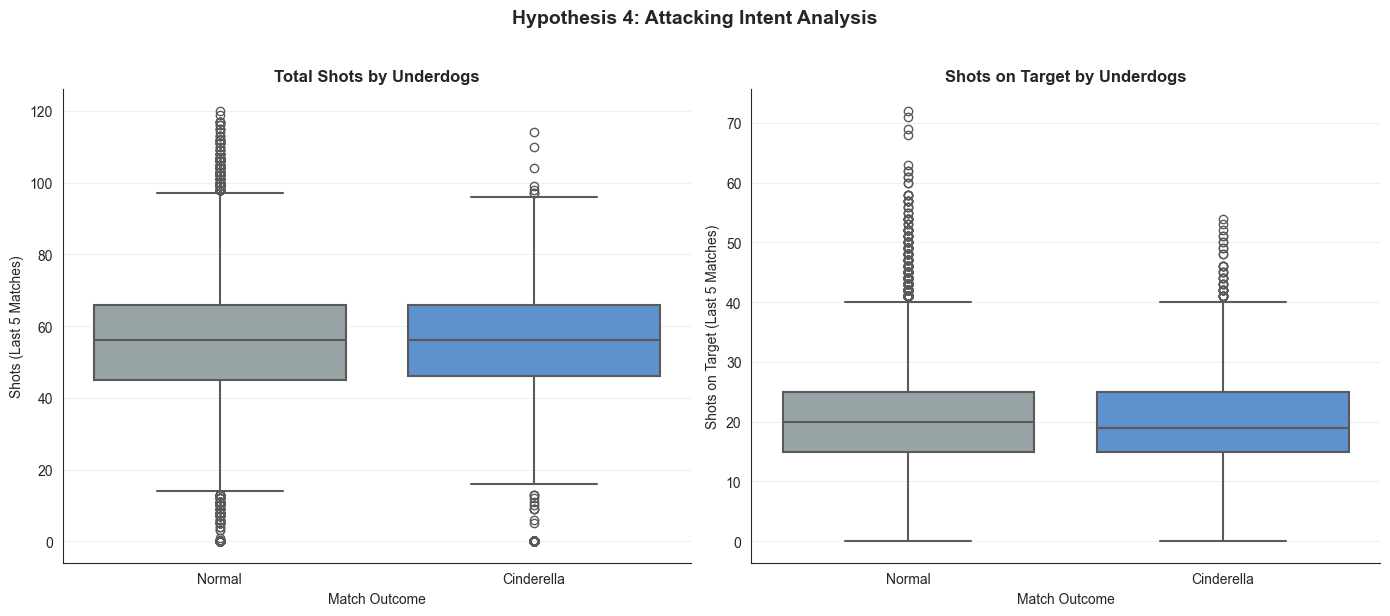


Median Shots5_underdog (Normal): 56.00
Median Shots5_underdog (Cinderella): 56.00
Increase in Cinderella matches: 0.00 shots

Median Target5_underdog (Normal): 20.00
Median Target5_underdog (Cinderella): 19.00
Increase in Cinderella matches: -1.00 shots on target


In [19]:
def plot_tactical_dominance(df):
    """
    Analyze offensive aggression of underdogs
    """
    df_valid = df[df['underdog'] != 'None'].copy()
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Shots
    sns.boxplot(
        data=df_valid, 
        x='is_cinderella', 
        y='Shots5_underdog',
        palette={'0': '#95a5a6', '1': '#4A90E2'},
        linewidth=1.5,
        ax=axes[0]
    )
    axes[0].set_title('Total Shots by Underdogs', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Match Outcome')
    axes[0].set_ylabel('Shots (Last 5 Matches)')
    axes[0].set_xticklabels(['Normal', 'Cinderella'])
    axes[0].grid(axis='y', alpha=0.3)
    
    # Shots on Target
    sns.boxplot(
        data=df_valid, 
        x='is_cinderella', 
        y='Target5_underdog',
        palette={'0': '#95a5a6', '1': '#4A90E2'},
        linewidth=1.5,
        ax=axes[1]
    )

    median_shots_normal = df_valid[df_valid['is_cinderella'] == 0]['Shots5_underdog'].median()
    median_shots_cinderella = df_valid[df_valid['is_cinderella'] == 1]['Shots5_underdog'].median()
    median_target_normal = df_valid[df_valid['is_cinderella'] == 0]['Target5_underdog'].median()
    median_target_cinderella = df_valid[df_valid['is_cinderella'] == 1]['Target5_underdog'].median()

    axes[1].set_title('Shots on Target by Underdogs', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Match Outcome')
    axes[1].set_ylabel('Shots on Target (Last 5 Matches)')
    axes[1].set_xticklabels(['Normal', 'Cinderella'])
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.suptitle('Hypothesis 4: Attacking Intent Analysis', fontsize=14, fontweight='bold', y=1.02)
    sns.despine()
    plt.tight_layout()
    plt.show()

    print(f"\nMedian Shots5_underdog (Normal): {median_shots_normal:.2f}")
    print(f"Median Shots5_underdog (Cinderella): {median_shots_cinderella:.2f}")
    print(f"Increase in Cinderella matches: {median_shots_cinderella - median_shots_normal:.2f} shots")
    print(f"\nMedian Target5_underdog (Normal): {median_target_normal:.2f}")
    print(f"Median Target5_underdog (Cinderella): {median_target_cinderella:.2f}")
    print(f"Increase in Cinderella matches: {median_target_cinderella - median_target_normal:.2f} shots on target")

plot_tactical_dominance(df_prepared)

### **Chart Analysis (Updated with Outlier Insight)**

#### Visualization Principles

*   **Chart Type:** Side-by-side Box Plots. This layout is effective for simultaneously comparing two related metrics (`Total Shots` and `Shots on Target`) for the underdog across the two outcome categories.
*   **Encoding:** The chart uses position and color consistently. Crucially, it displays outliers as individual points, which allows for analysis beyond the central tendency.
*   **Clarity & Storytelling:** The titles and labels clearly frame the "Attacking Intent" hypothesis. The visibility of outliers is key to uncovering a more nuanced insight.

#### What the Chart Explains

*   **Hypothesis Validation:** This pair of plots tests the hypothesis that underdogs who cause an upset show greater attacking intent in the matches leading up to it.

*   **Initial Observation (Median Analysis):**
    *   At first glance, the central tendency offers a surprising result. The median number of `Total Shots` (56.0) and `Shots on Target` (20.0) generated by underdog teams in their last 5 matches is **exactly the same** for both "Normal" and "Cinderella" outcomes.
    *   Based on the median alone, the simple hypothesis that "more shots lead to an upset" is **not supported**.

*   **Deeper Insight ("The Reckless Attacker" Effect from Outliers):**
    *   **Observation:** A more subtle and interesting pattern emerges from the outliers. The "Normal Match" category (where the underdog ultimately fails to win) exhibits a **significantly larger number and wider range of high-end outliers** for `Total Shots`. These represent underdog teams that generated an extremely high volume of shots (e.g., 100-120 in 5 matches) but still failed to secure an upset.
    *   **Interpretation:** This suggests a "Reckless Attacker" phenomenon. Some underdogs adopt a high-risk, high-volume attacking strategy. While this leads to an impressive number of total shots, it may compromise defensive stability or lack clinical finishing. The model appears to be picking up that an *abnormally high* shot count from an underdog is not necessarily a positive signal and is often associated with a "glorious failure" rather than a "Cinderella" victory.
    *   **Cinderella Profile:** In contrast, the "Cinderella Match" group has fewer extreme outliers. This implies that successful underdogs might not be the ones who attack recklessly, but rather those who are more **balanced and efficient**, achieving their wins without needing a massive, outlier-level shot volume.

*   **Overall Narrative Point:**
    *   **Beyond Simple Metrics:** This chart brilliantly demonstrates that relying solely on central tendency metrics like the median can be misleading. The real story is often hidden in the tails of the distribution.
    *   **A More Complex Signal:** The analysis refines our understanding. The key to an upset is not simply "more attacking intent," but perhaps "more *effective* attacking intent." A moderately high and consistent number of shots on target might be a better signal than a wild, outlier number of total shots.
    *   **Value of Machine Learning:** This complex, non-linear relationship (where "more" is not always better) is difficult to capture with simple rules but is precisely the kind of pattern a machine learning model, fed with well-prepared features, can learn. This chart validates the need for a sophisticated model over simple statistical comparisons.

## **1.6 Interaction Visualization: Elo Strength vs Momentum**

### Putting it Together

This scatter plot reveals how **momentum can counteract Elo disadvantage**, showing where Cinderella upsets cluster.

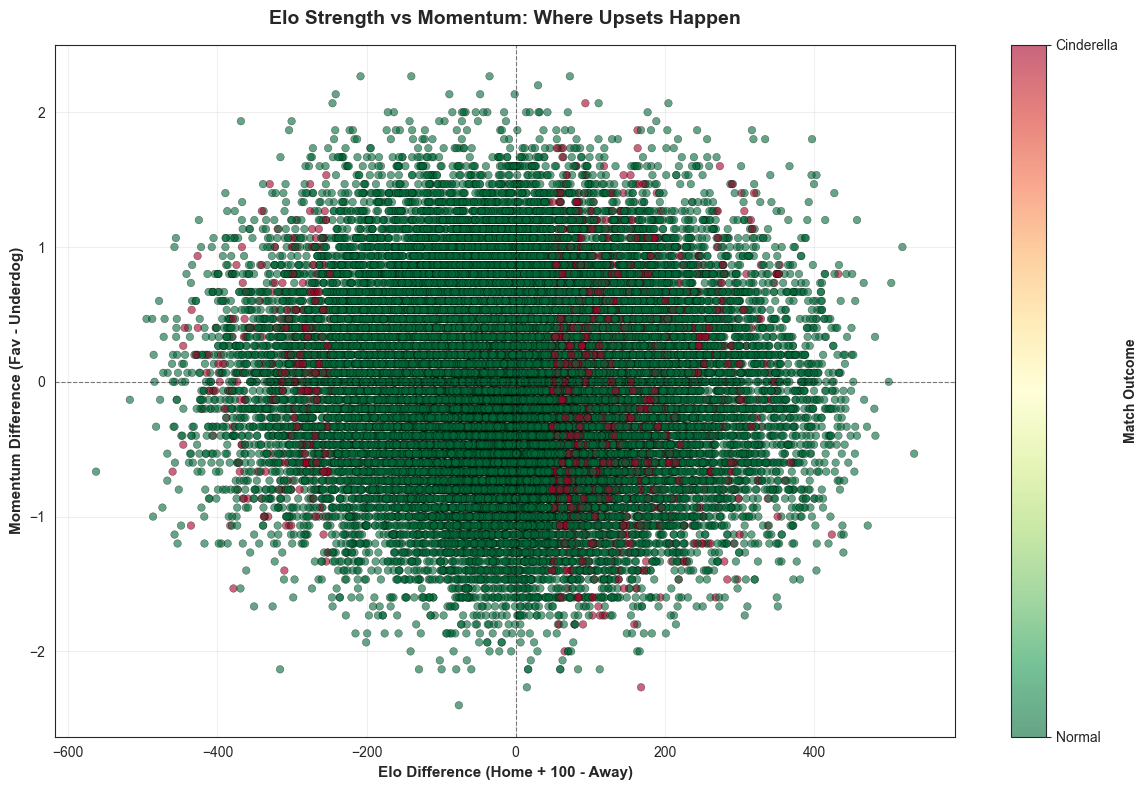


Interpretation:
- Red points (Cinderella) tend to cluster in regions where:
  1. Large positive Elo_diff (strong favorite) BUT
  2. Lower Momentum_diff (underdog has strong recent form)


In [11]:
def plot_elo_momentum_interaction(df):
    """
    Visualize the interaction between Elo difference and Momentum
    """
    df_valid = df[df['underdog'] != 'None'].copy()
    
    plt.figure(figsize=(12, 8))
    
    # Scatter plot
    scatter = plt.scatter(
        df_valid['Elo_diff'],
        df_valid['Momentum_diff'],
        c=df_valid['is_cinderella'],
        cmap='RdYlGn_r',
        alpha=0.6,
        s=30,
        edgecolors='black',
        linewidth=0.3
    )
    
    plt.xlabel('Elo Difference (Home + 100 - Away)', fontsize=11, fontweight='bold')
    plt.ylabel('Momentum Difference (Fav - Underdog)', fontsize=11, fontweight='bold')
    plt.title('Elo Strength vs Momentum: Where Upsets Happen', fontsize=14, fontweight='bold', pad=15)
    
    # Add reference lines
    plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
    plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
    
    # Color bar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Match Outcome', fontsize=10, fontweight='bold')
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels(['Normal', 'Cinderella'])
    
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("\nInterpretation:")
    print("- Red points (Cinderella) tend to cluster in regions where:")
    print("  1. Large positive Elo_diff (strong favorite) BUT")
    print("  2. Lower Momentum_diff (underdog has strong recent form)")

plot_elo_momentum_interaction(df_prepared)

### **Chart Analysis**

#### Visualization Principles

*   **Chart Type:** Scatter Plot. This chart is ideal for visualizing the relationship and potential interaction between two continuous variables (`Elo Difference` and `Momentum Difference`).
*   **Encoding:**
    *   **Position (X-Y):** The x-axis encodes the raw strength difference between the teams (`Elo_diff`), while the y-axis encodes the difference in their recent form (`Momentum_diff`).
    *   **Color:** A diverging colormap (`RdYlGn_r`) is used to map the binary outcome (`is_cinderella`). Red points represent upsets (Cinderella), while green points represent normal outcomes. This color choice is intuitive and effective.
    *   **Transparency (Alpha):** The use of `alpha` helps to mitigate overplotting, revealing the density of data points in different regions of the plot.
*   **Clarity & Storytelling:**
    *   **Quadrants:** The dashed reference lines at x=0 and y=0 divide the plot into four meaningful quadrants, simplifying interpretation.
    *   **Title:** The title, "Elo Strength vs Momentum: Where Upsets Happen," is highly effective. It sets a clear context and poses a question that the chart then answers visually.

#### What the Chart Explains

*   **Correction on Interpretation:** The printed interpretation has a slight error. The `Momentum Difference` is defined as `Fav - Underdog`. Therefore, a **lower (more negative)** value means the **underdog has better momentum**. The red points (Cinderella) cluster where `Momentum_diff` is low, not high.

*   **The "Upset Zone" (Main Insight):**
    *   The chart clearly shows that **Cinderella upsets (red dots) do not happen randomly**. They are concentrated in a specific region of the plot.
    *   **Quadrant Analysis:**
        *   **Bottom-Left Quadrant (`Elo_diff < 0`, `Momentum_diff < 0`):** This is where upsets are most frequent. This quadrant represents matches where the favorite is the away team (`Elo_diff` is negative) but the underdog (home team) has significantly better recent momentum (`Momentum_diff` is negative).
        *   **Bottom-Right Quadrant (`Elo_diff > 0`, `Momentum_diff < 0`):** Upsets also occur here. This represents matches where the favorite is the home team, but their momentum is weaker than the underdog's.
    *   **The Key Interaction:** The chart beautifully illustrates the interaction effect. A large strength disadvantage (a very negative or positive `Elo_diff`) can be **negated or counteracted by a strong momentum advantage** (a very negative `Momentum_diff`). The red points form a diagonal pattern, showing that the greater the strength gap, the more momentum the underdog needs to have a chance.

*   **Narrative Conclusion:**
    *   This is the culminating visual evidence of your EDA. It proves your central thesis: while `Elo_diff` sets the stage, it is the **interaction with engineered features like momentum** that truly explains where and when upsets are likely to happen.
    *   **Storytelling Point:** "This chart reveals the 'recipe' for a Cinderella story. An upset is most likely not just when there is a weak team, but when there is a weak team that is *in form* playing against a strong team that is *out of form*. Our data preparation allowed us to quantify both these effects and visualize their critical interaction, pinpointing the exact conditions where magic on the football pitch is most likely to happen."